# Time-Series Modeling Lesson with Stock Data
### Kwame V. Taylor

In [1]:
# imports
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt 

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

# default viz settings
plt.rc('figure', figsize=(12, 9))
plt.rc('font', size=14)
plt.rc('lines', linewidth=2, c='m')
plt.style.use('seaborn-whitegrid')

### Acquire and prepare the stock data.

In [2]:
# get stock data
from vega_datasets import data
stocks = data.stocks()
# to transform such that each symbol is it's own column and each row is one month
stocks.pivot_table('price', 'date', 'symbol')

symbol,AAPL,AMZN,GOOG,IBM,MSFT
date,,,,,
2000-01-01,25.94,64.56,NaN,100.52,39.81
2000-02-01,28.66,68.87,NaN,92.11,36.35
2000-03-01,33.95,67.00,NaN,106.11,43.22
2000-04-01,31.01,55.19,NaN,99.95,28.37
2000-05-01,21.00,48.31,NaN,96.31,25.45
...,...,...,...,...,...
2009-11-01,199.91,135.91,583.00,125.79,29.27
2009-12-01,210.73,134.52,619.98,130.32,30.34
2010-01-01,192.06,125.41,529.94,121.85,28.05


I just want to focus on IBM.

In [3]:
IBM = pd.DataFrame(stocks[stocks['symbol'] == 'IBM'])
IBM = stocks.pivot_table('price', 'date')
IBM

,price
date,
2000-01-01,57.7075
2000-02-01,56.4975
2000-03-01,62.5700
2000-04-01,53.6300
2000-05-01,47.7675
...,...
2009-11-01,214.7760
2009-12-01,225.1780
2010-01-01,199.4620


In [106]:
IBM.index

DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01',
               ...
               '2009-06-01', '2009-07-01', '2009-08-01', '2009-09-01',
               '2009-10-01', '2009-11-01', '2009-12-01', '2010-01-01',
               '2010-02-01', '2010-03-01'],
              dtype='datetime64[ns]', name='ds', length=123, freq=None)

In [4]:
IBM.isna().sum()

price    0
dtype: int64

In [5]:
IBM.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 123 entries, 2000-01-01 to 2010-03-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   123 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


I'll remove leap year days later if I have time.

### Split the data

In [6]:
train_size = int(len(IBM) * .5)
train_size

61

In [7]:
validate_size = int(len(IBM) * .3)
validate_size

36

In [8]:
test_size = int(len(IBM) - train_size - validate_size)
test_size

26

In [9]:
validate_end_index = train_size + validate_size
validate_end_index

97

In [10]:
# use the above values to split the df
train = IBM[: train_size]
validate = IBM[train_size:validate_end_index]
test = IBM[validate_end_index:]

**Verify the splits.**

Does the length of each df equate to the length of the original df?

In [11]:
print(len(train) + len(validate) + len(test) == len(IBM))

True


Does the first row of original df equate to the first row of train?

In [12]:
print(IBM.head(1) == train.head(1))

            price
date             
2000-01-01   True


Is the last row of train the month before the first row of validate? And the same for validate to test?

In [13]:
pd.concat([train.tail(1), validate.head(1)])

,price
date,
2005-01-01,77.558
2005-02-01,75.392


In [14]:
pd.concat([validate.tail(1), test.head(1)])

,price
date,
2008-01-01,182.248
2008-02-01,159.276


Is the last row of test the same as the last row of our original dataframe?

In [15]:
pd.concat([test.tail(1), IBM.tail(1)])

,price
date,
2010-03-01,213.276
2010-03-01,213.276


Let's plot our data first, viewing where the data is split into train and test.

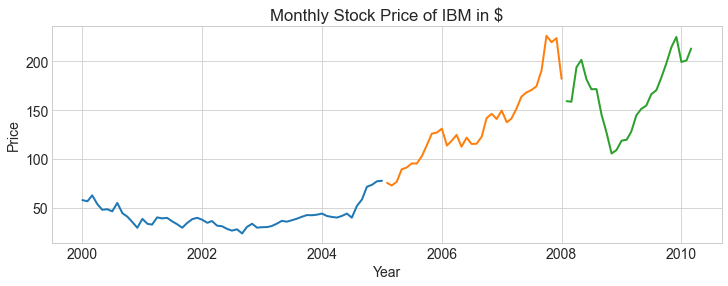

In [16]:
plt.figure(figsize=(12,4))
plt.plot(train['price'])
plt.plot(validate['price'])
plt.plot(test['price'])
plt.ylabel('Price')
plt.xlabel('Year')
plt.title('Monthly Stock Price of IBM in $')
plt.show()

Before we try out different methods for forecasting sales and number of items sold, let's create a couple of functions that will be helpful in evaluating each of the methods that follow.

```evaluate()``` will compute the Mean Squared Error and the Rood Mean Squared Error to evaluate.

In [17]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

```plot_and_eval()``` will use the evaluate function and also plot train and test values with the predicted values in order to compare performance.

In [18]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
#    plt.savefig('FirstSplitsForCyclesIBM.png', format='png')
    plt.show()

Write ```append_eval_df(model_type)``` to append evaluation metrics for each model type, target variable, and metric type, along with the metric value into our ```eval_df``` data frame object. Which we will create an empty ```eval_df``` dataframe object to start.

In [19]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [20]:
#eval_df

## Forecast
Forecasting is another word for predicting time series data.

1. Last Observed Value
2. Simple Average
3. Moving Average
4. Holt's Linear Trend
5. Previous Cycle

### Last observed value
The simplest method for forecasting is to predict all future values to be the last observed value.

**Make Predictions with last observed value**

Price

In [21]:
price = round(train['price'][-1:][0], 2)
price

77.56

In [22]:
yhat_df = pd.DataFrame({'price': [price]}, 
                      index = validate.index)

yhat_df.head()
yhat_df.describe()

,price
count,3.600000e+01
mean,7.756000e+01
std,4.323731e-14
min,7.756000e+01
25%,7.756000e+01
50%,7.756000e+01
75%,7.756000e+01
max,7.756000e+01


You can see, when peeking into yhat_df, that every predicted value is the same.

**Plot Actual vs. Predicted Values**

price -- RMSE: 70


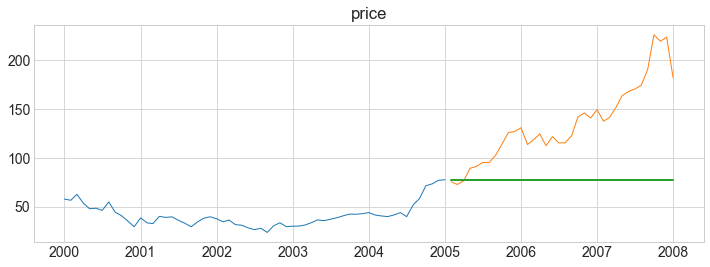

In [23]:
plot_and_eval('price')

Well, that's quite an unhelpful prediction!

**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to ```eval_df```

In [24]:
eval_df = append_eval_df(model_type = 'last_observed_value', target_var = 'price')
eval_df

,model_type,target_var,rmse
0,last_observed_value,price,70.0


### Simple Average
Take the simple average of historical values and use that value to predict future values.

This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train.

**Make Predictions**

Price: establishing the value of the prediction we will make

In [25]:
# compute simple average

# plt.plot(train['price'])
price = round(train['price'].mean(),2)
price

41.28

Apply predictions to our observations

In [26]:
yhat_df = pd.DataFrame({'price': [price]}, 
                      index = validate.index)

yhat_df.head()

,price
date,
2005-02-01,41.28
2005-03-01,41.28
2005-04-01,41.28
2005-05-01,41.28
2005-06-01,41.28


In [27]:
yhat_df.describe()

,price
count,3.600000e+01
mean,4.128000e+01
std,2.161866e-14
min,4.128000e+01
25%,4.128000e+01
50%,4.128000e+01
75%,4.128000e+01
max,4.128000e+01


**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Simple Average**.

This will probably perform worse than using the previous value to predict.

price -- RMSE: 102


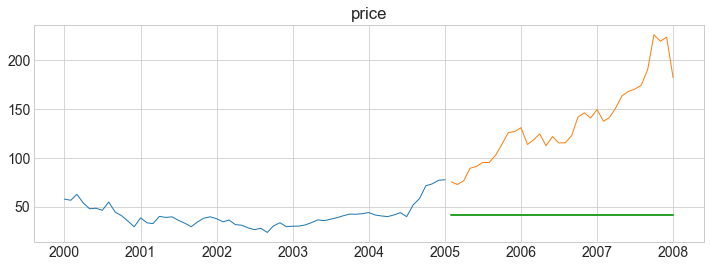

In [28]:
plot_and_eval('price')

**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to ```eval_df```

In [29]:
eval_df = append_eval_df(model_type='simple_average', target_var = 'price')
eval_df

,model_type,target_var,rmse
0,last_observed_value,price,70.0
1,simple_average,price,102.0


Last observed value is the best model so far.

### Moving Average

Since this data is monthly not daily, I will adjust the code from the lesson to suit it.

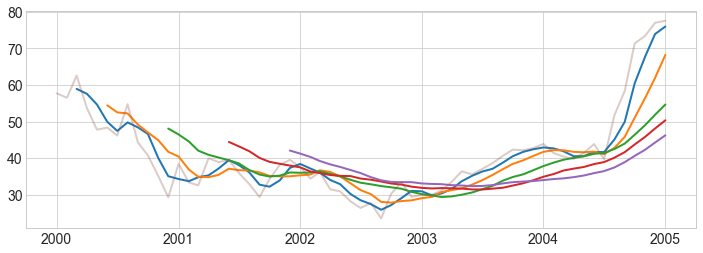

In [30]:
#train['dollars_sold'].tail(30)
plt.figure(figsize=(12,4))
plt.plot(train['price'].rolling(3).mean())
plt.plot(train['price'].rolling(6).mean())
plt.plot(train['price'].rolling(12).mean())
plt.plot(train['price'].rolling(18).mean())
plt.plot(train['price'].rolling(24).mean())
plt.plot(train['price'], alpha=.3)

In [31]:
# demonstrate that the mean of the first 30 days 
# is equal to rolling(30) on day 30

print(train['price'].rolling(30).mean()[29])
print(train['price'].head(30).mean())

40.27033333333334
40.27033333333334


**Make Predictions**

In [32]:
period = 3

price = round(train['price'].rolling(period).mean()[-1], 2)

print(price)

75.98


In [33]:
yhat_df = pd.DataFrame({'price': [price]}, index = validate.index)
yhat_df.head()

,price
date,
2005-02-01,75.98
2005-03-01,75.98
2005-04-01,75.98
2005-05-01,75.98
2005-06-01,75.98


**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Moving Average**

price -- RMSE: 71


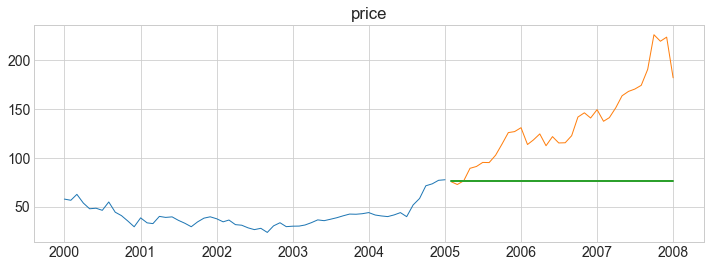

In [34]:
plot_and_eval('price')

**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to ```eval_df```

In [35]:
eval_df = append_eval_df(model_type = '3m_moving_avg', target_var = 'price')
eval_df

,model_type,target_var,rmse
0,last_observed_value,price,70.0
1,simple_average,price,102.0
2,3m_moving_avg,price,71.0


Let's try out several other values for periods:

In [36]:
periods = [1, 2, 6, 8, 12, 18, 24]

for p in periods: 
    price = round(train['price'].rolling(p).mean()[-1], 2)
    yhat_df = pd.DataFrame({'price': [price]}, index = validate.index)
    model_type = str(p) + 'm_moving_avg'
    eval_df = append_eval_df(model_type = model_type, target_var = 'price')

In [37]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,price,70.0
1,simple_average,price,102.0
2,3m_moving_avg,price,71.0
3,1m_moving_avg,price,70.0
4,2m_moving_avg,price,70.0
5,6m_moving_avg,price,78.0
6,8m_moving_avg,price,84.0
7,12m_moving_avg,price,90.0
8,18m_moving_avg,price,94.0
9,24m_moving_avg,price,97.0


Which is best so far?

In [38]:
min_items_rmse = eval_df[eval_df.target_var == 'price']['rmse'].min()

eval_df[eval_df.rmse == min_items_rmse]

,model_type,target_var,rmse
0,last_observed_value,price,70.0
3,1m_moving_avg,price,70.0
4,2m_moving_avg,price,70.0


### Holt's Linear Trend
Exponential smoothing applied to both the average and the trend (slope).

* $\alpha$ / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.
* $\beta$ / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values.

**Seasonal Decomposition**

First, let's take a look at the seasonal decomposition for each target.

price



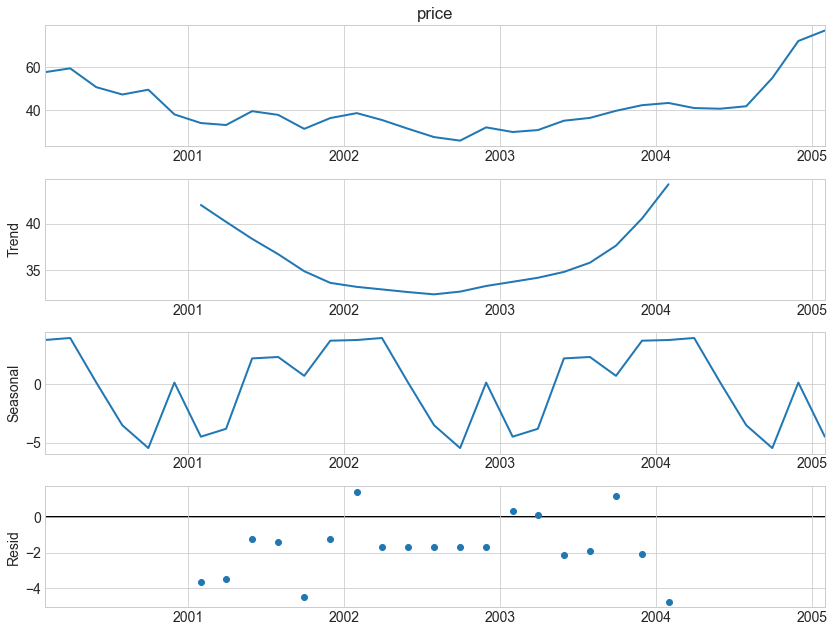

In [39]:
print('price\n')
sm.tsa.seasonal_decompose(train['price'].resample('2M').mean()).plot()
plt.show()

**Basic Holt's Linear Trend**

**Make Predictions**

Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions.

Holt:
* exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)
* damped $\phi$ = True/False: with Holt, forecasts will increase or decrease indefinitely into the future. To avoid this, use the Damped trend method which has a damping parameter 0< ϕ <1.

fit:
* smoothing_level ($\alpha$): value between (0,1)
* smoothing_slope ($\beta$): value between (0,1)
* optimized: use the auto-optimization that allow statsmodels to automatically find an optimized value for us.

In [40]:
model = Holt(train['price'], exponential=False, damped=True)
model = model.fit(optimized=True)
yhat_items = model.predict(start = validate.index[0], end = validate.index[-1])
yhat_df['price'] = round(yhat_items, 2)
yhat_df.head()

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


,price
date,
2005-02-01,79.62
2005-03-01,81.51
2005-04-01,83.33
2005-05-01,85.09
2005-06-01,86.79


price -- RMSE: 44


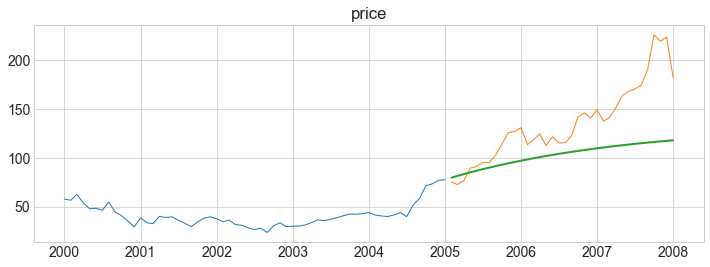

In [41]:
plot_and_eval('price')

**Evaluate**

In [42]:
eval_df = append_eval_df(model_type = 'holts_optimized', target_var = 'price')

In [43]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
10,holts_optimized,price,44.0
0,last_observed_value,price,70.0
3,1m_moving_avg,price,70.0
4,2m_moving_avg,price,70.0
2,3m_moving_avg,price,71.0
5,6m_moving_avg,price,78.0
6,8m_moving_avg,price,84.0
7,12m_moving_avg,price,90.0
8,18m_moving_avg,price,94.0
9,24m_moving_avg,price,97.0


Let's do another model, changing some hyperparameters.

In [44]:
model = Holt(train['price'], exponential=False)
model = model.fit(smoothing_level=.1, smoothing_slope=.1, optimized=False)
yhat_items = model.predict(start = validate.index[0], end = validate.index[-1])
yhat_df['price'] = round(yhat_items, 2)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


price -- RMSE: 46


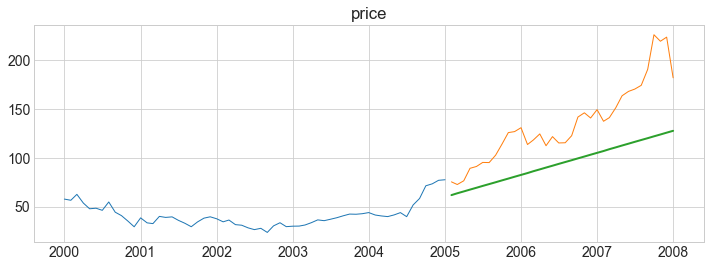

In [45]:
plot_and_eval('price')

In [46]:
eval_df = append_eval_df(model_type = 'holts_.1', target_var = 'price')
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
10,holts_optimized,price,44.0
11,holts_.1,price,46.0
0,last_observed_value,price,70.0
3,1m_moving_avg,price,70.0
4,2m_moving_avg,price,70.0
2,3m_moving_avg,price,71.0
5,6m_moving_avg,price,78.0
6,8m_moving_avg,price,84.0
7,12m_moving_avg,price,90.0
8,18m_moving_avg,price,94.0


### Predict Based on Previous Cycle
Take all the 2016 data points, compute the daily delta, year-over-year, average that delta over all the days, and adding that average to the previous year's value on a day will give you the forecast for that day.

If a primary cycle is weekly, then you may want to do this on a week-over-week cadence.

In the below example:

1. Compute the 365 average year over year differences from 2013 through 2015
2. Add that average delta to the values during 2015.
3. Set the index in your yhat dataframe to represent the dates those predictions are make for.

Let's get started...

**Re-split data**

In [47]:
IBM.tail()

,price
date,
2009-11-01,214.776
2009-12-01,225.178
2010-01-01,199.462
2010-02-01,201.130
2010-03-01,213.276


In [48]:
IBM.shape

(123, 1)

In [49]:
# i first tried splitting like:
# train[:2005], validate [2006], test [2007],
# but that accidentally truncated my data, whoops
# now I made sure the observations add up to 123

train = IBM[:'2006']
validate = IBM['2007':'2008']
test = IBM['2009':]

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()

(84, 1)
(24, 1)
(15, 1)


,price
date,
2000-01-01,57.7075
2000-02-01,56.4975
2000-03-01,62.5700
2000-04-01,53.6300
2000-05-01,47.7675


**Make Predictions**

In [50]:
# finding the year-over-year difference for each day from 2000 to 2007
# taking the mean, and then adding that value to the monthly 2007 values. 

yhat_df = train['2005':'2006'] + train.diff(12).mean()

In [51]:
# let's peek into the prediction we will make for 1/1/2016
# by comparing the predicted value 
# (2015 value + year-over-year average difference)
# to the actual 1/1/2016 value
pd.concat([yhat_df.head(1), validate.head(1)])

,price
date,
2005-01-01,90.447806
2007-01-01,149.552000


In [52]:
# set yhat_df to index of validate

yhat_df.index = validate.index

yhat_df.describe()

,price
count,24.000000
mean,123.210056
std,21.861958
min,85.559806
25%,107.086806
50%,127.519806
75%,137.847306
max,159.173806


In [53]:
yhat_df.head()

,price
date,
2007-01-01,90.447806
2007-02-01,88.281806
2007-03-01,85.559806
2007-04-01,89.383806
2007-05-01,102.197806


In [54]:
yhat_df.shape

(24, 1)

**Plot and Evaluate**

price -- RMSE: 59


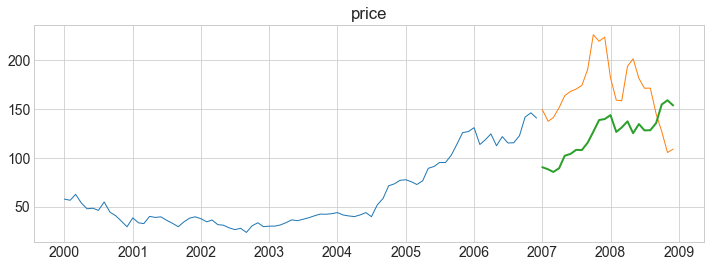

In [55]:
#plt.savefig('FirstSplitsForCyclesIBM.png', format='png')
plot_and_eval(target_var = 'price')
eval_df = append_eval_df(model_type = "previous_year", target_var = 'price')

This model would work even better if I could give more weight to the most recent train data. I also notice that the point where the prediction gets it dangerously wrong is when the stock market crashed in late 2008.

In [56]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,price,70.0
1,simple_average,price,102.0
2,3m_moving_avg,price,71.0
3,1m_moving_avg,price,70.0
4,2m_moving_avg,price,70.0
5,6m_moving_avg,price,78.0
6,8m_moving_avg,price,84.0
7,12m_moving_avg,price,90.0
8,18m_moving_avg,price,94.0
9,24m_moving_avg,price,97.0


### Predict with FB Prophet
> Prophet is open source software released by Facebook’s Core Data Science team. It is available for download on CRAN and PyPI.
> 
> Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well. According to Facebook, Prophet is "robust to outliers, missing data, and dramatic changes in your time series.

I want to know if FB Prophet can predict the 2008 stock market crash. I'm curious to find out.

**Import FB Prophet**

In [57]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import plot_forecast_component

**Re-prepare data**
* dataframe
* 2 columns ONLY: ds and y
* ds is a datestamp column formatted as YYYY-MM-DD (date) or YYYY-MM-DD HH:MM:SS (timestamp)
* y must be numeric and represents the measurement we wish to forecast.

In [58]:
IBM.head(2)

,price
date,
2000-01-01,57.7075
2000-02-01,56.4975


Rename the columns.

In [59]:
IBM = IBM.rename(columns={"price": "y"})
IBM = IBM.rename_axis('ds')
IBM.head(2)

,y
ds,
2000-01-01,57.7075
2000-02-01,56.4975


Make sure ds is a datetime and y is numeric.

In [60]:
IBM.index

DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01',
               ...
               '2009-06-01', '2009-07-01', '2009-08-01', '2009-09-01',
               '2009-10-01', '2009-11-01', '2009-12-01', '2010-01-01',
               '2010-02-01', '2010-03-01'],
              dtype='datetime64[ns]', name='ds', length=123, freq=None)

In [61]:
IBM.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 123 entries, 2000-01-01 to 2010-03-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       123 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


**Split the data**

In [62]:
train = IBM[:'2006']
validate = IBM['2007':'2008']
test = IBM['2009':]

print(train.shape)
print(validate.shape)
print(test.shape)

train.head(2)

(84, 1)
(24, 1)
(15, 1)


,y
ds,
2000-01-01,57.7075
2000-02-01,56.4975


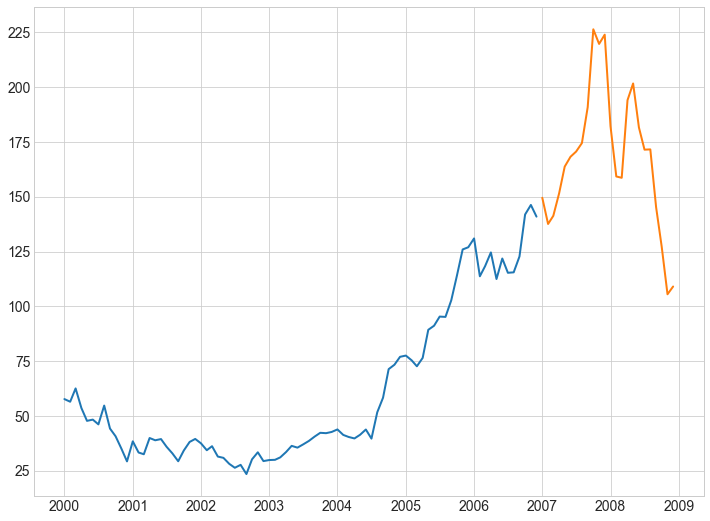

In [63]:
# verify train and validate dates by plotting
plt.plot(train)
plt.plot(validate)

Reset index as prophet needs ds to be a column and not an index. 

In [64]:
train = train.reset_index()
validate = validate.reset_index()
test = test.reset_index()

train.head(2)

,ds,y
0,2000-01-01,57.7075
1,2000-02-01,56.4975


Now the data is prepared and ready for the model.

**Create and Fit a Prophet Model**

In [65]:
# use my domain knowledge to set the cap and floor
train['cap'] = 1000
train['floor'] = 5

train.head(2)

,ds,y,cap,floor
0,2000-01-01,57.7075,300,5
1,2000-02-01,56.4975,300,5


In [66]:
m = Prophet(daily_seasonality = False,
            weekly_seasonality = False,
            seasonality_mode='multiplicative',
            growth = 'logistic',
            changepoint_range = 0.9)
m.add_seasonality(name='thirds', period=4, fourier_order=22)
m.add_seasonality(name='quarterly', period=3, fourier_order=15)
m.add_seasonality(name='yearly', period=12, fourier_order=20)
m.add_country_holidays(country_name='US')
m.fit(train)

print(m.train_holiday_names)

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.


0                  New Year's Day
1       New Year's Day (Observed)
2      Martin Luther King Jr. Day
3           Washington's Birthday
4                    Memorial Day
5                Independence Day
6                       Labor Day
7                    Columbus Day
8                    Veterans Day
9         Veterans Day (Observed)
10                   Thanksgiving
11                  Christmas Day
12    Independence Day (Observed)
13       Christmas Day (Observed)
dtype: object


**Make Predictions**

> Two ways to predict:
 * create a ```future``` dataframe and create predictions for those dates. (This is basically your test dataframe)
 * use Prophet's cross validation method to predict.

**Using Future DataFrame**

> For making predictions with a Prophet model, we will use the Prophet function make_future_dataframe(). The argument we will provide is ```periods```, the number of periods to make a prediction. In this case, our sampling frequency is daily, so our periods will be in terms of days. The make_future_dataframes() function, by default, will also include the dates from the original training dataset. We will also want our cap and floor included in the future dataframe.

In [67]:
future = m.make_future_dataframe(periods = len(validate))
future['cap'] = 1000
future['floor'] = 5

> The futures dataframe will start with the first date in train and end with the last date in validate. Predictions will be made on all the days, but the model only used values of y up to the last date in train.

In [68]:
pd.concat([future.head(2), future.tail(2)])

,ds,cap,floor
0,2000-01-01,300,5
1,2000-02-01,300,5
106,2006-12-24,300,5
107,2006-12-25,300,5


> The ```predict``` method will assign each row in ```future``` a predicted value, ```yhat```. If you pass in historical dates, it will provide an in-sample fit. The ```forecast``` object that is returned is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals (```yhat_lower``` and ```yhat_upper```)

In [98]:
forecast = m.predict(future)
forecast.head(2)

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,...,thirds,thirds_lower,thirds_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2000-01-01,6.197915,300,5,73.104148,110.877188,6.197915,6.197915,0.0,0.0,...,5.042494,5.042494,5.042494,2.322155,2.322155,2.322155,0.0,0.0,0.0,92.225932
1,2000-02-01,6.231649,300,5,67.136769,102.554542,6.231649,6.231649,0.0,0.0,...,5.106459,5.106459,5.106459,2.464395,2.464395,2.464395,0.0,0.0,0.0,85.535057


Take a look at the columns that are returned.

In [70]:
forecast.columns

Index(['ds', 'trend', 'cap', 'floor', 'yhat_lower', 'yhat_upper',
       'trend_lower', 'trend_upper', 'Christmas Day', 'Christmas Day_lower',
       'Christmas Day_upper', 'Christmas Day (Observed)',
       'Christmas Day (Observed)_lower', 'Christmas Day (Observed)_upper',
       'Columbus Day', 'Columbus Day_lower', 'Columbus Day_upper',
       'Independence Day', 'Independence Day_lower', 'Independence Day_upper',
       'Independence Day (Observed)', 'Independence Day (Observed)_lower',
       'Independence Day (Observed)_upper', 'Labor Day', 'Labor Day_lower',
       'Labor Day_upper', 'Martin Luther King Jr. Day',
       'Martin Luther King Jr. Day_lower', 'Martin Luther King Jr. Day_upper',
       'Memorial Day', 'Memorial Day_lower', 'Memorial Day_upper',
       'New Year's Day', 'New Year's Day_lower', 'New Year's Day_upper',
       'New Year's Day (Observed)', 'New Year's Day (Observed)_lower',
       'New Year's Day (Observed)_upper', 'Thanksgiving', 'Thanksgiving_lower',
 

Peek into the last predictions, including the confidence interval.

In [71]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
103,2006-12-21,194.257710,176.115301,213.027743
104,2006-12-22,194.650548,176.384330,211.576420
105,2006-12-23,174.438798,154.267372,192.362631
106,2006-12-24,193.292759,174.031011,211.456059
107,2006-12-25,197.210689,178.221737,214.881736


**Evaluate**

We can evaluate by compute the RMSE.

In [72]:
eval_df = pd.merge(IBM, forecast[['ds', 'yhat']], how = 'inner', on = 'ds')

rmse = sqrt(mean_squared_error(eval_df.y, eval_df.yhat))
rmse

54.98364078625324

In [73]:
eval_df

,ds,y,yhat
0,2000-01-01,57.7075,92.225932
1,2000-02-01,56.4975,85.535057
2,2000-03-01,62.5700,83.438180
3,2000-04-01,53.6300,86.468455
4,2000-05-01,47.7675,83.932586
...,...,...,...
79,2006-08-01,115.5380,160.193919
80,2006-09-01,122.7880,164.532701
81,2006-10-01,141.9160,183.853342
82,2006-11-01,146.2840,212.297768


**Visualize Predictions**

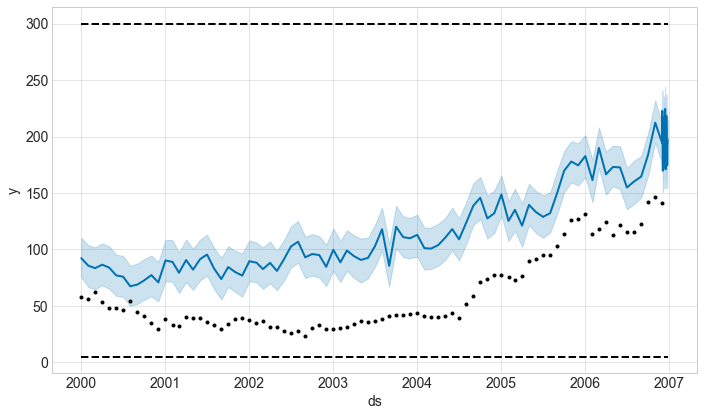

In [74]:
fig1 = m.plot(forecast)

In [103]:
eval_df.head()

,ds,y,yhat
0,2000-01-01,57.7075,92.225932
1,2000-02-01,56.4975,85.535057
2,2000-03-01,62.5700,83.438180
3,2000-04-01,53.6300,86.468455
4,2000-05-01,47.7675,83.932586


In [109]:
# get stock data
from vega_datasets import data
stocks = data.stocks()
# to transform such that each symbol is it's own column and each row is one month
stocks.pivot_table('price', 'date', 'symbol')

IBM = pd.DataFrame(stocks[stocks['symbol'] == 'IBM'])
IBM = stocks.pivot_table('price', 'date')
IBM.head(3)

,price
date,
2000-01-01,57.7075
2000-02-01,56.4975
2000-03-01,62.5700


In [112]:
#IBM_predictions = pd.concat([IBM, eval_df])
#IBM_predictions

In [119]:
eval_df.dtypes

ds      datetime64[ns]
y              float64
yhat           float64
dtype: object

I'll figure out the code for this visualization later.

> To see the forecast components, we can call Prophet.plot_components(). By default we'll see the trend, yearly seasonality, and weekly seasonality of the time series. We can opt to include holidays, also.

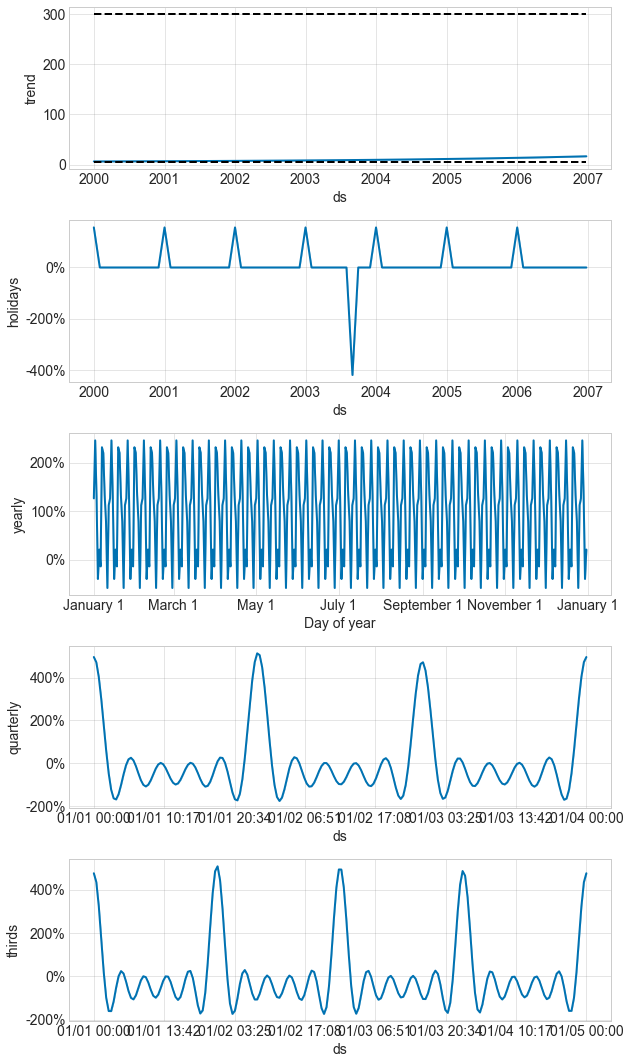

In [75]:
fig2 = m.plot_components(forecast, 'holidays')

In [115]:
#plot_and_eval(target_var = 'y')
#eval_df = append_eval_df(model_type = "FB_prophet", target_var = 'y')

### Conclusion

Which model did the best?

In [77]:
#price_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

# find which model that is
#eval_df[(eval_df.rmse == price_min_rmse)]

Let's test it out on our out-of-sample data

We will be using train + validate to predict test.

In [78]:
#yhat_df = validate + train.diff(12).mean()
#yhat_df.index = test.index

In [120]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

In [80]:
#rmse_price = sqrt(mean_squared_error(test['price'], yhat_df['price']))

In [81]:
#print('rmse-price: ', rmse_price)

In [122]:
#final_plot('price')

In [83]:
# to predict 2018

#yhat_df = test + train.diff(12).mean()

#yhat_df.index = test.index + pd.Timedelta('1Y')

In [84]:
#yhat_df.head()

In [85]:
#final_plot('price')

___

## Exercises

The end result of this exercise should be a Jupyter notebook named ```model```.

Using <a href="https://ds.codeup.com/saas.csv">saas.csv</a>, log data from API usage, ```store_item_sales```, or the ```vega_datasets``` stock data.

1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.
2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
   * Simple Average
   * Moving Average
   * Holt's Linear Trend Model
   * Based on previous year/month/etc., this is up to you.

Optional: Using store item demand
1. Predict 2018 total monthly sales for a single store and/or item by creating a model using prophet.
2. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).
3. Plot the 2018 monthly sales predictions.